In [38]:
# ensure latest module is used
from importlib import reload
import project_functions
reload(project_functions)

# import relevant libraries
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from project_functions import get_lap, plot_traj_reward, plot_misalignment, interpolate_trajectories, print_huber_losses
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# PD Control Training Data

In [39]:
foldername = "test_data"

# get pd data
filepath_pd = os.path.join(foldername, 'test_pd_data.csv')
df_pd = pd.read_csv(filepath_pd)

x_pd = df_pd['cur_pos_x'].values
y_pd = df_pd['cur_pos_z'].values
ytrue = df_pd['steering_angle']

x_pd_lap, y_pd_lap = get_lap(x_pd, y_pd, 0.03, 0.03)
reward_pd_lap = df_pd['reward'].values[-len(x_pd_lap):]
neg_reward_pd = len([x for x in reward_pd_lap if x < 0])
print(f"Negative Reward Count: {neg_reward_pd}")

# get ground truth data
filepath_gt = os.path.join(foldername, 'gt_udem1.csv')
df_gt = pd.read_csv(filepath_gt)

x_gt = df_gt['bez_x'].values
y_gt = df_gt['bez_z'].values

x_gt_lap, y_gt_lap = get_lap(x_gt, y_gt, 0.03, 0.03)

Negative Reward Count: 1923


## Raw Data - Unweighted

Negative Reward Count: 2056
Model Test Huber Loss: 0.10230555438079605
PD and Model Huber Loss: 0.05074250412871949
Ground Truth and Model Huber Loss: 0.05540875169804523


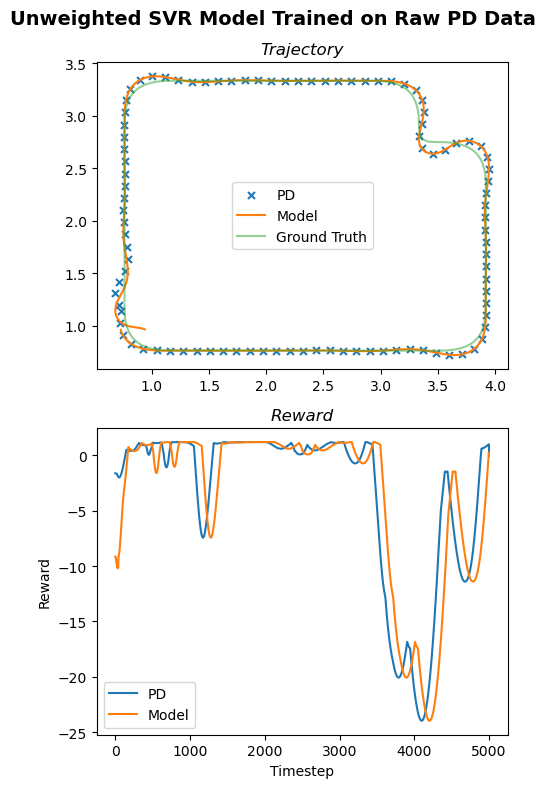

/Users/sophiachiang/Documents/ELEN90088/elen90088_final/project/project_functions.py:160: RuntimeWarning: invalid value encountered in divide
  cosine_angle = dot_product / (magnitude1 * magnitude2)


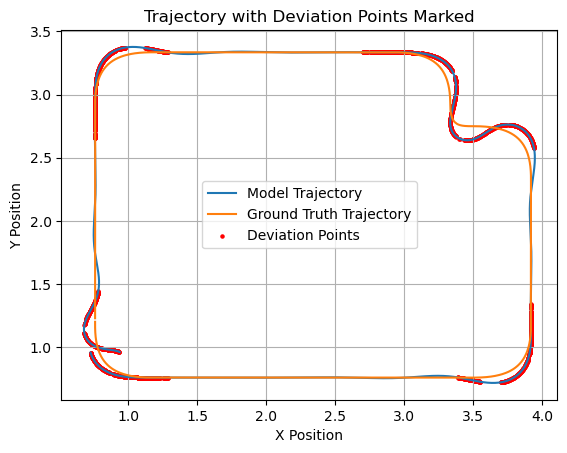

Time Spent Misaligned: 1992


In [15]:
model_name = "unweighted_svr_model_raw_pd"

# get base model with raw data test results
filepath = os.path.join(foldername, f'test_{model_name}_data.csv')
df_model = pd.read_csv(filepath)

x_model = df_model['cur_pos_x'].values
y_model = df_model['cur_pos_z'].values

x_model = df_model['cur_pos_x'].values
y_model = df_model['cur_pos_z'].values

df_model['steering_angle'] = df_model['steering_angle'].apply(lambda x: float(x.replace('[', '').replace(']', '')))
ypred = df_model['steering_angle'].values
x_model_lap, y_model_lap = get_lap(x_model, y_model, 0.7, 0.005)
reward_model_lap = df_model['reward'].values[-len(x_model_lap):]
neg_reward_model = len([x for x in reward_model_lap if x < 0])
print(f"Negative Reward Count: {neg_reward_model}")

# evaluate model on test data
x_gt_interp, y_gt_interp, x_pd_interp, y_pd_interp = interpolate_trajectories(x_gt_lap, y_gt_lap, x_pd_lap, y_pd_lap, x_model_lap, y_model_lap)

# ensure ypred and ytrue lengths match
ytrue = ytrue[:len(ypred)]
ypred = ypred[:len(ytrue)]

print_huber_losses(ytrue, ypred, x_pd_interp, y_pd_interp, x_gt_interp, y_gt_interp, x_model_lap, y_model_lap)

plot_traj_reward(x_pd_lap, y_pd_lap, x_model_lap, y_model_lap, x_gt_lap, y_gt_lap, df_model, df_pd, "Unweighted SVR Model Trained on Raw PD Data")
plot_misalignment(x_model_lap, y_model_lap, x_gt_lap, y_gt_lap)

## Raw Data - Weighted

Negative Reward Count: 1930
Model Test Huber Loss: 0.04494061799599221
PD and Model Huber Loss: 0.014248318437848339
Ground Truth and Model Huber Loss: 0.01086388908929632


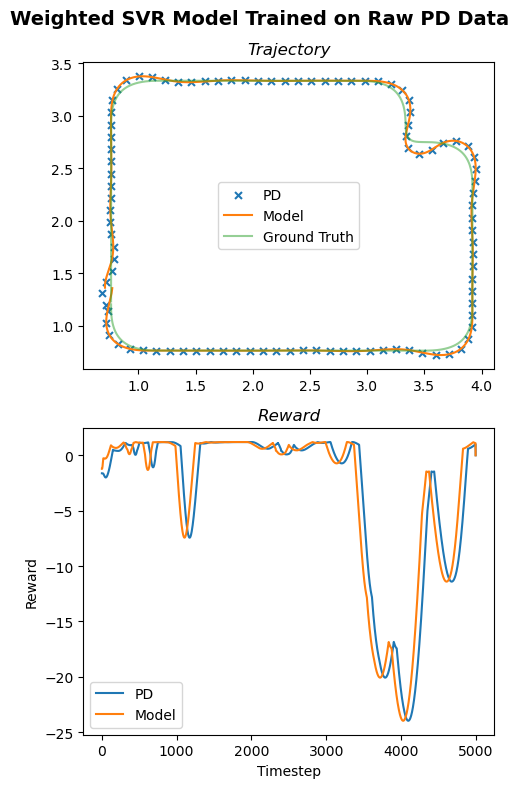

/Users/sophiachiang/Documents/ELEN90088/elen90088_final/project/project_functions.py:160: RuntimeWarning: invalid value encountered in divide
  cosine_angle = dot_product / (magnitude1 * magnitude2)


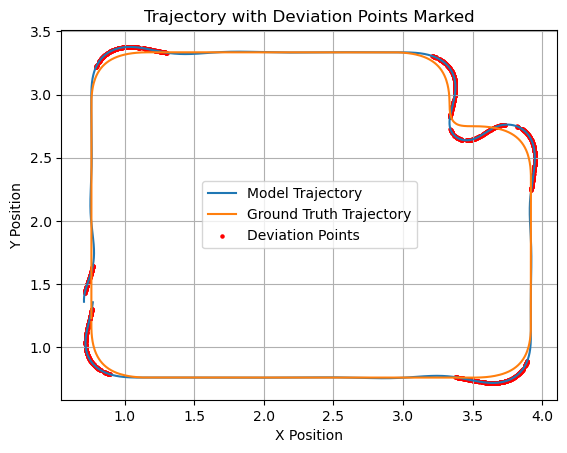

Time Spent Misaligned: 1415


In [16]:
model_name = "weighted_svr_model_raw_pd"

# get base model with raw data test results
filepath = os.path.join(foldername, f'test_{model_name}_data.csv')
df_model = pd.read_csv(filepath)

x_model = df_model['cur_pos_x'].values
y_model = df_model['cur_pos_z'].values

x_model = df_model['cur_pos_x'].values
y_model = df_model['cur_pos_z'].values

df_model['steering_angle'] = df_model['steering_angle'].apply(lambda x: float(x.replace('[', '').replace(']', '')))
ypred = df_model['steering_angle'].values
x_model_lap, y_model_lap = get_lap(x_model, y_model, 0.7, 0.005)
reward_model_lap = df_model['reward'].values[-len(x_model_lap):]
neg_reward_model = len([x for x in reward_model_lap if x < 0])
print(f"Negative Reward Count: {neg_reward_model}")

# evaluate model on test data
x_gt_interp, y_gt_interp, x_pd_interp, y_pd_interp = interpolate_trajectories(x_gt_lap, y_gt_lap, x_pd_lap, y_pd_lap, x_model_lap, y_model_lap)

# ensure ypred and ytrue lengths match
ytrue = ytrue[:len(ypred)]
ypred = ypred[:len(ytrue)]

print_huber_losses(ytrue, ypred, x_pd_interp, y_pd_interp, x_gt_interp, y_gt_interp, x_model_lap, y_model_lap)
plot_traj_reward(x_pd_lap, y_pd_lap, x_model_lap, y_model_lap, x_gt_lap, y_gt_lap, df_model, df_pd, "Weighted SVR Model Trained on Raw PD Data")
plot_misalignment(x_model_lap, y_model_lap, x_gt_lap, y_gt_lap)


## Processed Data - Unweighted

Negative Reward Count: 2834
Model Test Huber Loss: 0.1055967342896053
PD and Model Huber Loss: 1.8594452432020976
Ground Truth and Model Huber Loss: 1.8466296741289636


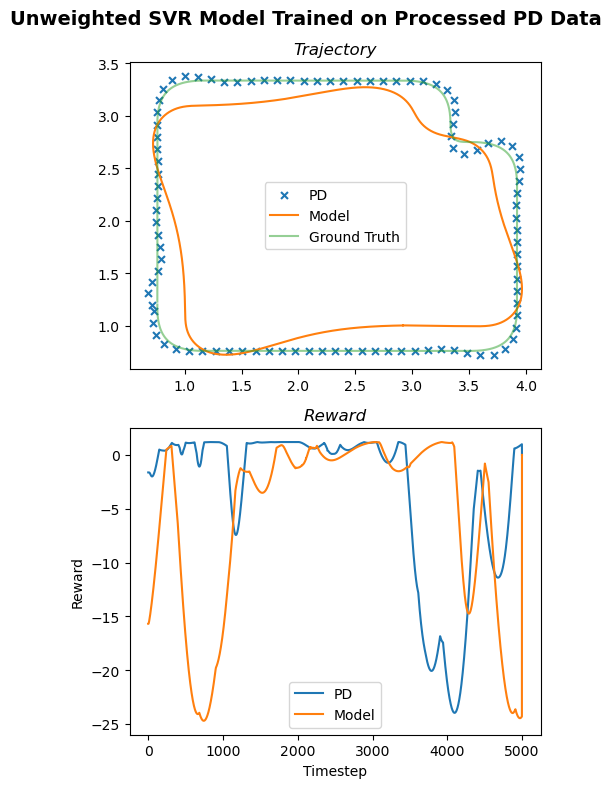

/Users/sophiachiang/Documents/ELEN90088/elen90088_final/project/project_functions.py:160: RuntimeWarning: invalid value encountered in divide
  cosine_angle = dot_product / (magnitude1 * magnitude2)


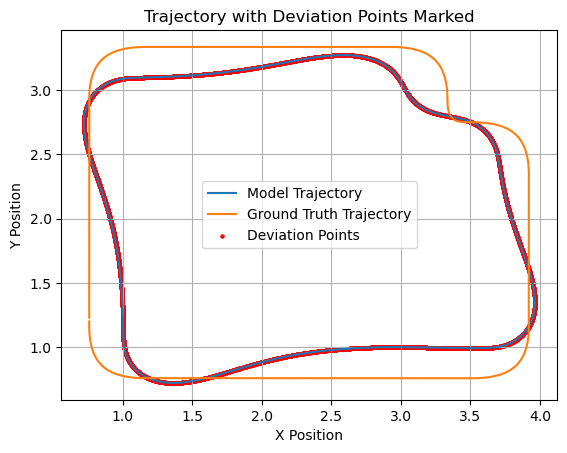

Time Spent Misaligned: 4164


In [17]:
model_name = "unweighted_svr_model_processed_pd"

# get base model with raw data test results
filepath = os.path.join(foldername, f'test_{model_name}_data.csv')
df_model = pd.read_csv(filepath)

x_model = df_model['cur_pos_x'].values
y_model = df_model['cur_pos_z'].values

x_model = df_model['cur_pos_x'].values
y_model = df_model['cur_pos_z'].values

df_model['steering_angle'] = df_model['steering_angle'].apply(lambda x: float(x.replace('[', '').replace(']', '')))
ypred = df_model['steering_angle'].values
x_model_lap, y_model_lap = get_lap(x_model, y_model, 0.005, 0.005)
reward_model_lap = df_model['reward'].values[-len(x_model_lap):]
neg_reward_model = len([x for x in reward_model_lap if x < 0])
print(f"Negative Reward Count: {neg_reward_model}")

# evaluate model on test data
x_gt_interp, y_gt_interp, x_pd_interp, y_pd_interp = interpolate_trajectories(x_gt_lap, y_gt_lap, x_pd_lap, y_pd_lap, x_model_lap, y_model_lap)

# ensure ypred and ytrue lengths match
ytrue = ytrue[:len(ypred)]
ypred = ypred[:len(ytrue)]

print_huber_losses(ytrue, ypred, x_pd_interp, y_pd_interp, x_gt_interp, y_gt_interp, x_model_lap, y_model_lap)
plot_traj_reward(x_pd_lap, y_pd_lap, x_model_lap, y_model_lap, x_gt_lap, y_gt_lap, df_model, df_pd, "Unweighted SVR Model Trained on Processed PD Data")
plot_misalignment(x_model_lap, y_model_lap, x_gt_lap, y_gt_lap)

## Processed Data - Unweighted Polynomial Features

Negative Reward Count: 1970
Model Test Huber Loss: 0.057754147164699586
PD and Model Huber Loss: 0.0028347072159921145
Ground Truth and Model Huber Loss: 0.004570003703275248


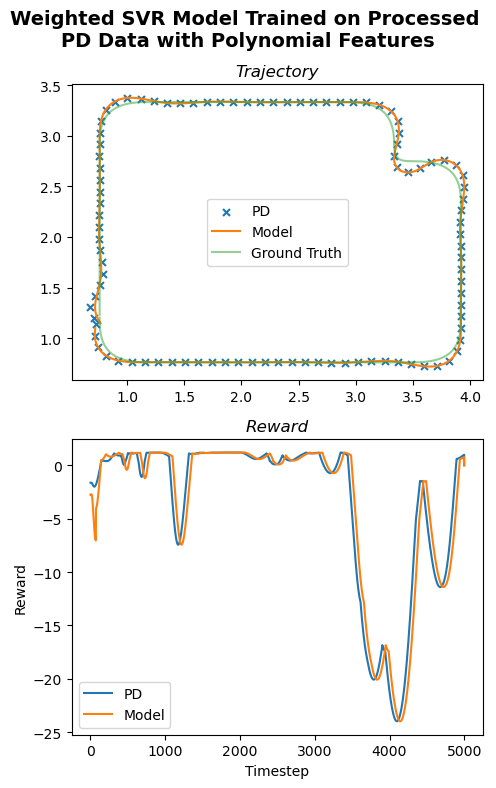

/Users/sophiachiang/Documents/ELEN90088/elen90088_final/project/project_functions.py:160: RuntimeWarning: invalid value encountered in divide
  cosine_angle = dot_product / (magnitude1 * magnitude2)


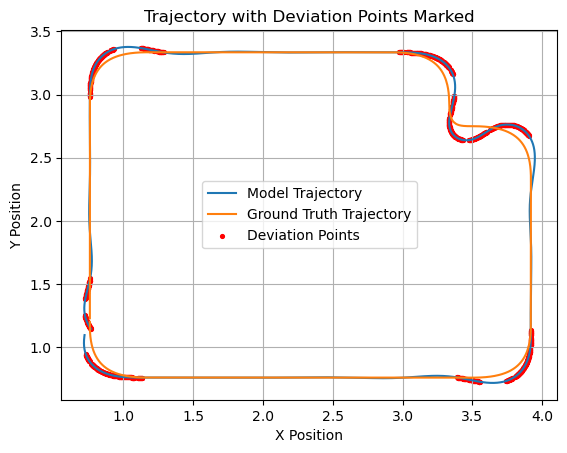

Time Spent Misaligned: 1316


In [36]:
model_name = "unweighted_svr_poly_processed_pd"

# get base model with raw data test results
filepath = os.path.join(foldername, f'test_{model_name}_data.csv')
df_model = pd.read_csv(filepath)

x_model = df_model['cur_pos_x'].values
y_model = df_model['cur_pos_z'].values

x_model = df_model['cur_pos_x'].values
y_model = df_model['cur_pos_z'].values

df_model['steering_angle'] = df_model['steering_angle'].apply(lambda x: float(x.replace('[', '').replace(']', '')))
ypred = df_model['steering_angle'].values
x_model_lap, y_model_lap = get_lap(x_model, y_model, 0.05, 0.05)
reward_model_lap = df_model['reward'].values[-len(x_model_lap):]
neg_reward_model = len([x for x in reward_model_lap if x < 0])
print(f"Negative Reward Count: {neg_reward_model}")

# evaluate model on test data
x_gt_interp, y_gt_interp, x_pd_interp, y_pd_interp = interpolate_trajectories(x_gt_lap, y_gt_lap, x_pd_lap, y_pd_lap, x_model_lap, y_model_lap)

# ensure ypred and ytrue lengths match
ytrue = ytrue[:len(ypred)]
ypred = ypred[:len(ytrue)]

print_huber_losses(ytrue, ypred, x_pd_interp, y_pd_interp, x_gt_interp, y_gt_interp, x_model_lap, y_model_lap)
plot_traj_reward(x_pd_lap, y_pd_lap, x_model_lap, y_model_lap, x_gt_lap, y_gt_lap, df_model, df_pd, "Weighted SVR Model Trained on Processed \nPD Data with Polynomial Features")
plot_misalignment(x_model_lap, y_model_lap, x_gt_lap, y_gt_lap)

## Processed Data - Weighted

Negative Reward Count: 2839
Model Test Huber Loss: 0.09992907828422254
PD and Model Huber Loss: 1.8456702903890343
Ground Truth and Model Huber Loss: 1.8329580388393016


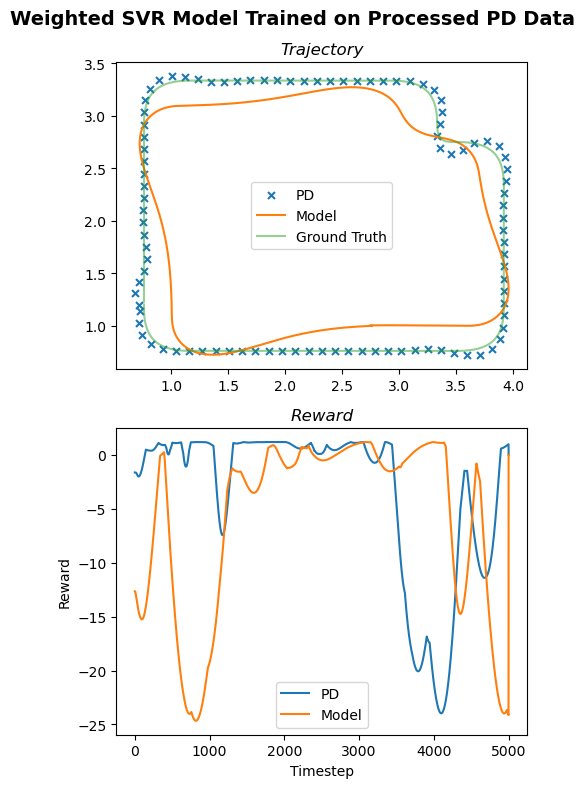

/Users/sophiachiang/Documents/ELEN90088/elen90088_final/project/project_functions.py:160: RuntimeWarning: invalid value encountered in divide
  cosine_angle = dot_product / (magnitude1 * magnitude2)


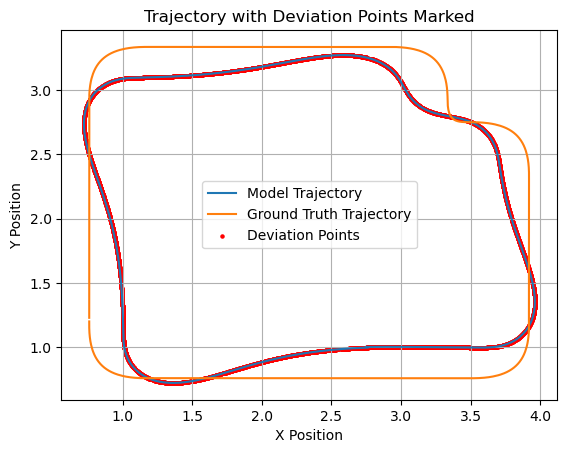

Time Spent Misaligned: 4171


In [18]:
model_name = "weighted_svr_model_processed_pd"

# get base model with raw data test results
filepath = os.path.join(foldername, f'test_{model_name}_data.csv')
df_model = pd.read_csv(filepath)

x_model = df_model['cur_pos_x'].values
y_model = df_model['cur_pos_z'].values

x_model = df_model['cur_pos_x'].values
y_model = df_model['cur_pos_z'].values

df_model['steering_angle'] = df_model['steering_angle'].apply(lambda x: float(x.replace('[', '').replace(']', '')))
ypred = df_model['steering_angle'].values
x_model_lap, y_model_lap = get_lap(x_model, y_model, 0.05, 0.005)
reward_model_lap = df_model['reward'].values[-len(x_model_lap):]
neg_reward_model = len([x for x in reward_model_lap if x < 0])
print(f"Negative Reward Count: {neg_reward_model}")

# evaluate model on test data
x_gt_interp, y_gt_interp, x_pd_interp, y_pd_interp = interpolate_trajectories(x_gt_lap, y_gt_lap, x_pd_lap, y_pd_lap, x_model_lap, y_model_lap)

# ensure ypred and ytrue lengths match
ytrue = ytrue[:len(ypred)]
ypred = ypred[:len(ytrue)]

print_huber_losses(ytrue, ypred, x_pd_interp, y_pd_interp, x_gt_interp, y_gt_interp, x_model_lap, y_model_lap)
plot_traj_reward(x_pd_lap, y_pd_lap, x_model_lap, y_model_lap, x_gt_lap, y_gt_lap, df_model, df_pd, "Weighted SVR Model Trained on Processed PD Data")
plot_misalignment(x_model_lap, y_model_lap, x_gt_lap, y_gt_lap)

## Processed Data - Weighted Polynomial Features

Negative Reward Count: 1998
Model Test Huber Loss: 0.1305490351634239
PD and Model Huber Loss: 0.04153209037449794
Ground Truth and Model Huber Loss: 0.045559043543053346


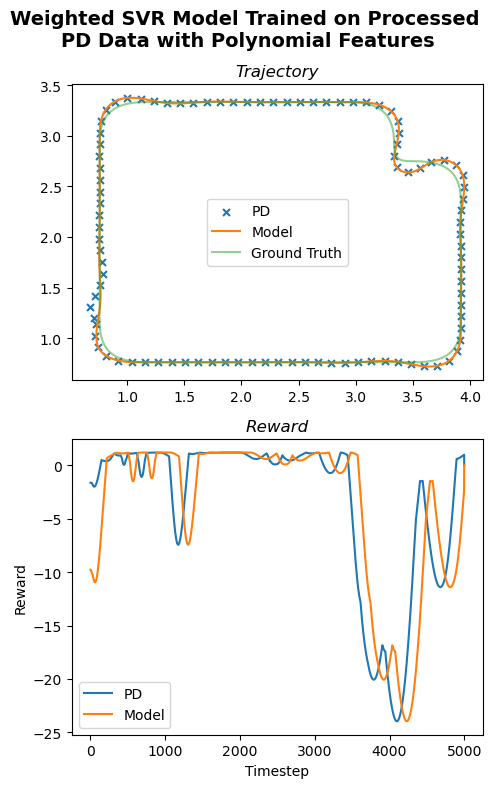

/Users/sophiachiang/Documents/ELEN90088/elen90088_final/project/project_functions.py:160: RuntimeWarning: invalid value encountered in divide
  cosine_angle = dot_product / (magnitude1 * magnitude2)


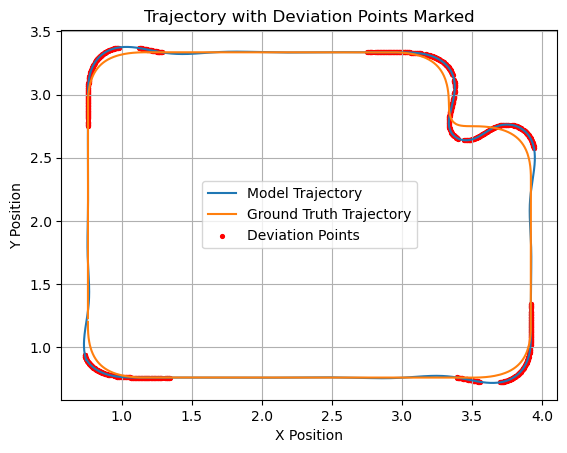

Time Spent Misaligned: 1426


In [27]:
model_name = "weighted_svr_poly_processed_pd"

# get base model with raw data test results
filepath = os.path.join(foldername, f'test_{model_name}_data.csv')
df_model = pd.read_csv(filepath)

x_model = df_model['cur_pos_x'].values
y_model = df_model['cur_pos_z'].values

x_model = df_model['cur_pos_x'].values
y_model = df_model['cur_pos_z'].values

df_model['steering_angle'] = df_model['steering_angle'].apply(lambda x: float(x.replace('[', '').replace(']', '')))
ypred = df_model['steering_angle'].values
x_model_lap, y_model_lap = get_lap(x_model, y_model, 0.05, 0.005)
reward_model_lap = df_model['reward'].values[-len(x_model_lap):]
neg_reward_model = len([x for x in reward_model_lap if x < 0])
print(f"Negative Reward Count: {neg_reward_model}")

# evaluate model on test data
x_gt_interp, y_gt_interp, x_pd_interp, y_pd_interp = interpolate_trajectories(x_gt_lap, y_gt_lap, x_pd_lap, y_pd_lap, x_model_lap, y_model_lap)

# ensure ypred and ytrue lengths match
ytrue = ytrue[:len(ypred)]
ypred = ypred[:len(ytrue)]

print_huber_losses(ytrue, ypred, x_pd_interp, y_pd_interp, x_gt_interp, y_gt_interp, x_model_lap, y_model_lap)
plot_traj_reward(x_pd_lap, y_pd_lap, x_model_lap, y_model_lap, x_gt_lap, y_gt_lap, df_model, df_pd, "Weighted SVR Model Trained on Processed \nPD Data with Polynomial Features")
plot_misalignment(x_model_lap, y_model_lap, x_gt_lap, y_gt_lap)